https://www.kaggle.com/competitions/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

In [67]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt

import pickle as pkl

## Load data

In [68]:
pd.set_option('display.max_columns', 30)

In [69]:
train_df = pd.read_csv(r'train_sessions.csv')
test_df = pd.read_csv(r'test_sessions.csv')

In [70]:
train_df.shape

(253561, 22)

In [71]:
test_df.shape

(82797, 21)

In [72]:
with open(r'site_dic.pkl', 'rb') as file:
    site_dic = pkl.load(file)

site_dic_inv = pd.Series({v:k for k,v in site_dic.items()})
site_dic_inv.name = 'site_name'

## Preprocess

In [73]:
time_cols = [f'time{i}' for i in range(1,11)]
site_cols = [f'site{i}' for i in range(1,11)]

In [74]:
# datetime to format
for col in time_cols:
    train_df[col] = pd.to_datetime(train_df[col], format="%Y-%m-%d %H:%M:%S")
    test_df[col] = pd.to_datetime(test_df[col], format="%Y-%m-%d %H:%M:%S")    

In [75]:
def extract_date_features(df, date_column='time1'):
    
    #df['start_date'] = df[date_column].dt.date
    df['start_year'] = df[date_column].dt.year
    df['start_month'] = df[date_column].dt.month
    df['start_year_month'] = df[date_column].dt.strftime('%Y%m')
    df['start_week'] = df[date_column].dt.isocalendar().week
    df['start_day'] = df[date_column].dt.day
    df['start_weekday'] = df[date_column].dt.weekday
    df['start_is_weekend'] = df['start_weekday'].isin([5, 6]).astype(int)
    df['start_hour'] = df['time1'].dt.hour
    
    return df

In [76]:
train_df = extract_date_features(train_df)
test_df = extract_date_features(test_df)

In [77]:
def extract_session_times_features(df):
    
    df['session_len'] = df[time_cols].notna().sum(axis=1)
    df['session_duration'] = (df[time_cols].max(axis=1) - df[time_cols].min(axis=1)).dt.total_seconds()
    df['session_delta_mean'] = df[time_cols].diff(axis=1).mean(axis=1).dt.total_seconds().fillna(0)
    df['session_delta_std'] = df[time_cols].diff(axis=1).std(axis=1).dt.total_seconds().fillna(0)
    df['session_delta_min'] = df[time_cols].diff(axis=1).min(axis=1).dt.total_seconds().fillna(0)
    df['session_delta_max'] = df[time_cols].diff(axis=1).max(axis=1).dt.total_seconds().fillna(0)
    
    return df

In [78]:
train_df = extract_session_times_features(train_df)
test_df = extract_session_times_features(test_df)

In [79]:
# sites which ALice used

df_sites_visit = pd.DataFrame()

for col in site_cols:
    df_sites_visit = pd.concat([df_sites_visit,
                                train_df[[col, 'target']].rename(columns={col:'site'})],
                               ignore_index=True)
    
df_sites_visit['cnt'] = 1
    
df_sites_visit_piv = df_sites_visit.pivot_table(index='site', columns='target', values='cnt',
                                               aggfunc='sum', fill_value=0).reset_index()

df_sites_visit_piv['freq'] = df_sites_visit_piv[1] / (df_sites_visit_piv[0]+df_sites_visit_piv[1])
df_sites_visit_piv['cnt'] = 1
df_sites_visit_piv.index = df_sites_visit_piv.site

# lists of alices sites
alice_uses_sites = df_sites_visit_piv[df_sites_visit_piv['freq']>0]['cnt']
alice_sites = df_sites_visit_piv[df_sites_visit_piv['freq']>0.5]['cnt']

In [80]:
def add_alises_popular_sites(df):
    
    df_tmp = df[site_cols].copy()
    
    for col in site_cols:
        df_tmp = df_tmp.merge(alice_uses_sites, how='left', left_on=col, right_index=True, validate='m:1')
        df_tmp = df_tmp.rename(columns={'cnt': col+'_is_pop'})
        
    for col in site_cols:
        df_tmp = df_tmp.merge(alice_sites, how='left', left_on=col, right_index=True, validate='m:1')
        df_tmp = df_tmp.rename(columns={'cnt': col+'_is_so_pop'})
        
    sites_pop = [col+'_is_pop' for col in site_cols]
    sites_so_pop = [col+'_is_so_pop' for col in site_cols]
    
    df_tmp['alice_uses_sites'] = df_tmp[sites_pop].sum(axis=1)
    df_tmp['alice_sites'] = df_tmp[sites_so_pop].sum(axis=1)
    
    df = df.join(df_tmp[['alice_uses_sites', 'alice_sites']])
    
    return df

In [81]:
train_df = add_alises_popular_sites(train_df)
test_df = add_alises_popular_sites(test_df)

In [82]:
def add_sites_len_metrics(df):
    
    df_tmp = df[site_cols].copy()
    
    for col in site_cols:
        df_tmp = df_tmp.merge(site_dic_inv, how='left', left_on=col, right_index=True, validate='m:1')
        df_tmp = df_tmp.rename(columns={'site_name': col+'_name'})
    
    site_cols_names = [col+'_name' for col in site_cols]
    
    df_tmp['sites_nunique'] = df_tmp[site_cols_names].nunique(axis=1)
    
    df_tmp[site_cols_names] = df_tmp[site_cols_names].fillna(method='pad', axis=1)
    df_tmp['sites_len_mean'] = df_tmp[site_cols_names].applymap(len).mean(axis=1)
    df_tmp['sites_len_std'] = df_tmp[site_cols_names].applymap(len).std(axis=1)
    df_tmp['sites_len_min'] = df_tmp[site_cols_names].applymap(len).min(axis=1)
    df_tmp['sites_len_max'] = df_tmp[site_cols_names].applymap(len).max(axis=1)
    
    df = df.join(df_tmp[['sites_nunique','sites_len_mean','sites_len_std','sites_len_min','sites_len_max']])
    
    return df

In [83]:
train_df = add_sites_len_metrics(train_df)
test_df = add_sites_len_metrics(test_df)

In [84]:
def filtered_by_mask(df):
    
    f_start_month = [1,2,3,4,9,10,11,12]
    f_start_weekday = [0,1,3,4]
    f_start_hour = [12, 13, 16, 17,18]
    
    df = df[(df['start_month'].isin(f_start_month))
            & (df['start_weekday'].isin(f_start_weekday))
            & (df['start_hour'].isin(f_start_hour))]
    
    return df

In [85]:
# train_df_filtred = filtered_by_mask(train_df)

In [86]:
train_df_filtred = train_df

In [87]:
train_df_filtred['target'].value_counts(1)

0    0.990941
1    0.009059
Name: target, dtype: float64

## Train data I

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve

from catboost import CatBoostClassifier
import optuna

In [89]:
TRAIN_COLS = [
    'start_year','start_month','start_week',    
    'start_day','start_weekday','start_is_weekend','start_hour',    
    'session_len','session_duration','session_delta_mean','session_delta_std','session_delta_min','session_delta_max',    
    'alice_uses_sites','alice_sites',    
    'sites_nunique','sites_len_mean','sites_len_std','sites_len_min','sites_len_max'    
]

TARGET_COL = 'target'

In [90]:
X_train, X_test, y_train, y_test = train_test_split(train_df_filtred[TRAIN_COLS],
                                                    train_df_filtred[TARGET_COL],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=train_df_filtred[TARGET_COL])

In [91]:
def objective(trial):
    
    # model params
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'Precision',

        'task_type': 'GPU',
        'devices':'0',
        
        'auto_class_weights': 'Balanced',
        
        'random_seed': 42,
        'verbose': 0,
        
        'iterations': 3000,
        'early_stopping_rounds': 100,
        
        'depth': trial.suggest_int('depth', 4, 10),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0)   
        
    }
    
    # to save
    best_iters = []
    
    score_auc = []
    score_f1 = []
    score_precision = []
    score_recall = []
    score_acc_balanced = []
    
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    
    #cv
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
    
        model.fit(X_train_t, y_train_t,
                  eval_set=[(X_val, y_val)],
                  verbose=0)
    
        preds = model.predict(X_val)
        preds_prob = model.predict_proba(X_val)[:,1]
        
        best_iters.append(model.best_iteration_)
        
        score_auc.append(roc_auc_score(y_val, preds_prob))
        score_f1.append(f1_score(y_val, preds))
        score_precision.append(precision_score(y_val, preds))
        score_recall.append(recall_score(y_val, preds))
        score_acc_balanced.append(balanced_accuracy_score(y_val, preds))
    
    trial.set_user_attr('best_iters', best_iters)
    
    trial.set_user_attr('score_auc', score_auc)
    trial.set_user_attr('score_f1', score_f1)
    trial.set_user_attr('score_precision', score_precision)
    trial.set_user_attr('score_recall', score_recall)   
    trial.set_user_attr('score_acc_balanced', score_acc_balanced)    
    
    return np.mean(score_precision)

In [92]:
# # fit
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [93]:
# print('Score ROC AUC:   ', np.mean(study.best_trial.user_attrs['score_auc']))
# print('Score f1:        ', np.mean(study.best_trial.user_attrs['score_f1']))
# print('Score precision: ', np.mean(study.best_trial.user_attrs['score_precision']))
# print('Score recall:    ', np.mean(study.best_trial.user_attrs['score_recall']))
# print('Score Bld Acc:   ', np.mean(study.best_trial.user_attrs['score_acc_balanced']))

In [94]:
# print('Best iter:', study.best_trial.user_attrs['best_iters'])
# print('Best model params:', study.best_trial.params)

#### evaluate

In [95]:
mdl_params_first = {
    'loss_function': 'Logloss',
    'eval_metric': 'F1',

    'task_type': 'GPU',
    'devices':'0',

    'auto_class_weights': 'Balanced',

    'random_seed': 42,
    'verbose': 0,

    'iterations': 202,
    'depth': 10,
    
    'learning_rate': 0.10087483162934309,
    'l2_leaf_reg': 5.93641768479246,
    
    'random_strength': 0.6208112566677679
}

In [96]:
model = CatBoostClassifier(**mdl_params_first)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

0:	learn: 0.9792927	test: 0.9709399	best: 0.9709399 (0)	total: 29.6ms	remaining: 5.96s
50:	learn: 0.9966656	test: 0.9842504	best: 0.9842504 (50)	total: 1.34s	remaining: 3.97s
100:	learn: 0.9981602	test: 0.9835584	best: 0.9845391 (93)	total: 2.65s	remaining: 2.65s
150:	learn: 0.9986487	test: 0.9793927	best: 0.9845391 (93)	total: 3.97s	remaining: 1.34s
200:	learn: 0.9989663	test: 0.9783698	best: 0.9845391 (93)	total: 5.26s	remaining: 26.2ms
201:	learn: 0.9989688	test: 0.9783798	best: 0.9845391 (93)	total: 5.29s	remaining: 0us
bestTest = 0.9845391316
bestIteration = 93
Shrink model to first 94 iterations.


In [97]:
preds = model.predict(X_test)
preds_proba = model.predict_proba(X_test)[:,1]

In [98]:
print(confusion_matrix(y_test, preds))

[[50031   223]
 [   12   447]]


In [99]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50254
           1       0.67      0.97      0.79       459

    accuracy                           1.00     50713
   macro avg       0.83      0.98      0.89     50713
weighted avg       1.00      1.00      1.00     50713



In [100]:
print('roc_auc_score   ', roc_auc_score(y_test, preds_proba))
print('f1_score        ', f1_score(y_test, preds))
print('bld_acc_score   ', balanced_accuracy_score(y_test, preds))
print('precision_score ', precision_score(y_test, preds))
print('recall_score    ', recall_score(y_test, preds))

roc_auc_score    0.9985022490974607
f1_score         0.79185119574845
bld_acc_score    0.984709375717759
precision_score  0.6671641791044776
recall_score     0.9738562091503268


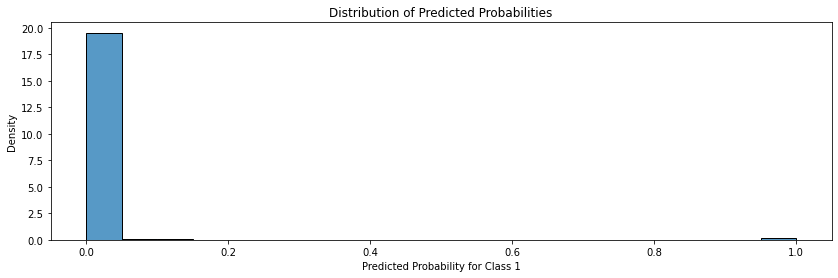

In [101]:
plt.figure(figsize=(14, 4))
sns.histplot(preds_proba, stat='density', bins=20)

plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities")
plt.show()

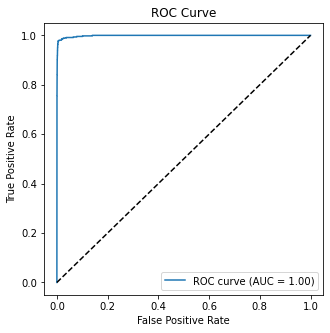

In [102]:
# ROC CURVE
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

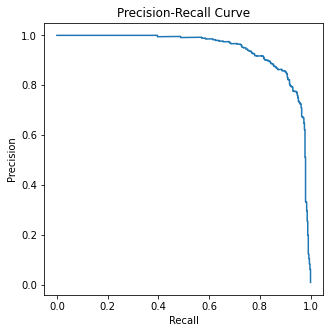

In [103]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds_proba)

plt.figure(figsize=(5,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

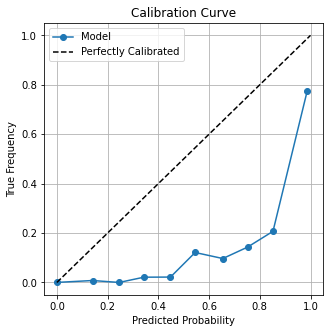

In [104]:
prob_true, prob_pred = calibration_curve(y_test, preds_proba, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

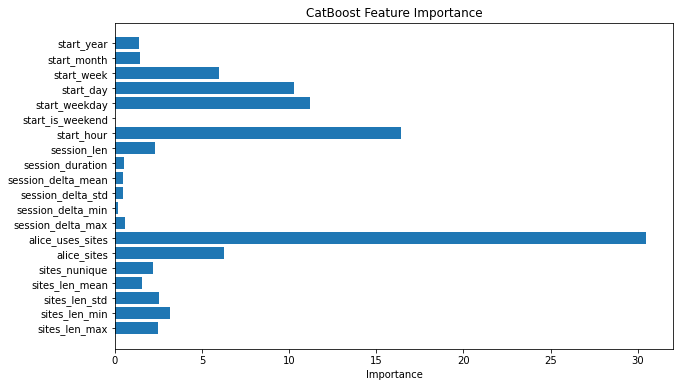

In [105]:
plt.figure(figsize=(10, 6))
plt.barh(model.feature_names_, model.feature_importances_)
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [106]:
# final first model
model_first_cb = CatBoostClassifier(**mdl_params_first)
model_first_cb.fit(train_df_filtred[TRAIN_COLS], train_df_filtred[TARGET_COL], verbose=50)

0:	learn: 0.9782967	total: 27.9ms	remaining: 5.62s
50:	learn: 0.9965593	total: 1.37s	remaining: 4.05s
100:	learn: 0.9980556	total: 2.72s	remaining: 2.72s
150:	learn: 0.9985514	total: 4.06s	remaining: 1.37s
200:	learn: 0.9988750	total: 5.41s	remaining: 26.9ms
201:	learn: 0.9988789	total: 5.44s	remaining: 0us


## Train data II, III

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#### Model for TfidfVectorizer

In [108]:
def oof_pred(df):
    
    idx = 1
    df_oof = pd.DataFrame()
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df[TRAIN_COLS], df[TARGET_COL]):
        X_t, X_v = df.iloc[train_idx], df.iloc[val_idx]
        
        model = CatBoostClassifier(**mdl_params_first)        
        model.fit(X_t[TRAIN_COLS], X_t[TARGET_COL], verbose=0)
        
        df_tmp = X_v.copy()        
        df_tmp['preds_frst_model'] = model.predict_proba(df_tmp[TRAIN_COLS])[:,1]
        
        df_oof = pd.concat([df_oof, df_tmp])
        
        print('Iter', idx)
        idx += 1
        
    df_oof = df_oof.sort_index()
    return df_oof        

In [109]:
train_df_filtred = oof_pred(train_df_filtred)

Iter 1
Iter 2
Iter 3
Iter 4
Iter 5


In [110]:
def get_words_features(df):
    
    df['words'] = (df[site_cols]
                   .fillna(0)
                   .astype('int')
                   .astype('str')
                   .apply(lambda s: ' '.join(s), axis=1))
    
    return df

In [111]:
train_df_filtred = get_words_features(train_df_filtred)

In [112]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)

vec_features = vectorizer.fit_transform(train_df_filtred['words'])
vec_target = train_df_filtred['target'].astype('int').values

In [113]:
linear_model = LogisticRegression(C=7.5, random_state=42, solver='liblinear')

cv_scores = cross_val_score(linear_model,
                            vec_features,
                            vec_target,
                            cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
                            scoring='roc_auc',
                            n_jobs=4)

print('CV scores', cv_scores)
print(f'CV mean: {cv_scores.mean()}, CV std: {cv_scores.std()}')

CV scores [0.96212474 0.96119109 0.96723734 0.96057504]
CV mean: 0.9627820531876818, CV std: 0.002630766287928333


In [114]:
linear_second_model = LogisticRegression(C=7.5, random_state=42, solver='liblinear')
linear_second_model.fit(vec_features, vec_target)

LogisticRegression(C=7.5, random_state=42, solver='liblinear')

In [115]:
# train_df_filtred['preds_scnd_model'] = linear_model.predict_proba(vec_features)[:,1]

#### Fin stacked model

In [116]:
# for ln model
def oof_pred(df):
    
    idx = 1
    df_oof = pd.DataFrame()
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df[TRAIN_COLS], df[TARGET_COL]):
        X_t, X_v = df.iloc[train_idx], df.iloc[val_idx]
        
        vec_prep = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
        vec_feat = vec_prep.fit_transform(X_t['words'])
        vec_trgt = X_t['target'].astype('int').values
        
        linear_model = LogisticRegression(C=7.5, random_state=42, solver='liblinear')
        linear_model.fit(vec_feat, vec_trgt)
        
        vec_feat_v = vec_prep.transform(X_v['words'])
        
        df_tmp = X_v.copy() 
        df_tmp['preds_scnd_model'] = linear_model.predict_proba(vec_feat_v)[:,1]
        
        df_oof = pd.concat([df_oof, df_tmp])
        
        print('Iter', idx)
        idx += 1
        
    df_oof = df_oof.sort_index()
    return df_oof        

In [117]:
train_df_filtred = oof_pred(train_df_filtred)

Iter 1
Iter 2
Iter 3
Iter 4
Iter 5


In [118]:
TRAIN_ST_COLS = ['preds_frst_model', 'preds_scnd_model']

In [119]:
linear_model_fin = LogisticRegression(C=1.2, random_state=42, solver='liblinear')

cv_scores = cross_val_score(linear_model_fin,
                            train_df_filtred[TRAIN_ST_COLS],
                            train_df_filtred[TARGET_COL],
                            cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
                            scoring='roc_auc',
                            n_jobs=4)

print('CV scores', cv_scores)
print(f'CV mean: {cv_scores.mean()}, CV std: {cv_scores.std()}')

linear_model_fin.fit(train_df_filtred[TRAIN_ST_COLS],train_df_filtred[TARGET_COL])

CV scores [0.99784655 0.997412   0.99820101 0.99903931]
CV mean: 0.9981247167721002, CV std: 0.0005974213009925657


LogisticRegression(C=1.2, random_state=42, solver='liblinear')

In [120]:
preds = linear_model_fin.predict(train_df_filtred[TRAIN_ST_COLS])
preds_proba = linear_model_fin.predict_proba(train_df_filtred[TRAIN_ST_COLS])[:,1]
y_test = train_df_filtred[TARGET_COL]

print('roc_auc_score   ', roc_auc_score(y_test, preds_proba))
print('f1_score        ', f1_score(y_test, preds))
print('bld_acc_score   ', balanced_accuracy_score(y_test, preds))
print('precision_score ', precision_score(y_test, preds))
print('recall_score    ', recall_score(y_test, preds))

roc_auc_score    0.9981186821650025
f1_score         0.8916752312435766
bld_acc_score    0.9713435851356872
precision_score  0.844626168224299
recall_score     0.9442751414888986


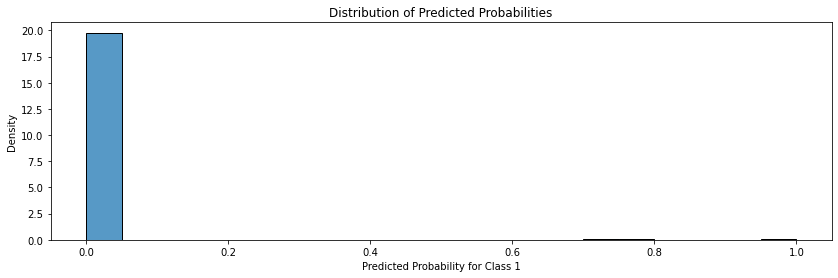

In [121]:
plt.figure(figsize=(14, 4))
sns.histplot(preds_proba, stat='density', bins=20)

plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities")
plt.show()

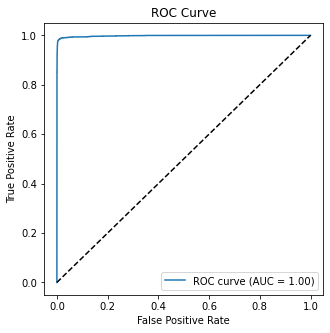

In [122]:
# ROC CURVE
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

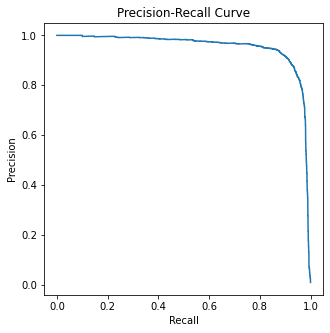

In [123]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds_proba)

plt.figure(figsize=(5,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

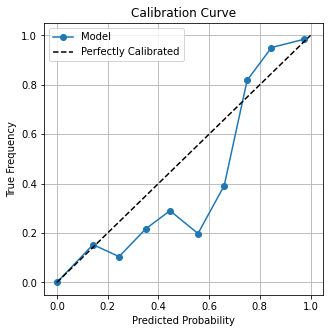

In [124]:
prob_true, prob_pred = calibration_curve(y_test, preds_proba, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

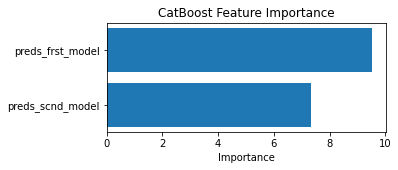

In [125]:
plt.figure(figsize=(5, 2))
plt.barh(linear_model_fin.feature_names_in_, linear_model_fin.coef_[0])
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Predict

In [126]:
# preds filtered
test_df_filtred = filtered_by_mask(test_df).copy()

test_df_filtred['preds_frst_model'] = model_first_cb.predict_proba(test_df_filtred[TRAIN_COLS])[:,1]

test_df_filtred = get_words_features(test_df_filtred)
vec_features_test = vectorizer.transform(test_df_filtred['words'])
test_df_filtred['preds_scnd_model'] = linear_second_model.predict_proba(vec_features_test)[:,1]

test_df_filtred['target_fl'] = linear_model_fin.predict_proba(test_df_filtred[TRAIN_ST_COLS])[:,1]

In [127]:
# preds full data
test_df['preds_frst_model'] = model_first_cb.predict_proba(test_df[TRAIN_COLS])[:,1]

test_df = get_words_features(test_df)
vec_features_test = vectorizer.transform(test_df['words'])
test_df['preds_scnd_model'] = linear_second_model.predict_proba(vec_features_test)[:,1]

test_df['target'] = linear_model_fin.predict_proba(test_df[TRAIN_ST_COLS])[:,1]

In [128]:
test_df = test_df.join(test_df_filtred[['target_fl']])
test_df['target_fl'] = test_df['target_fl'].fillna(0)

In [129]:
test_df[['session_id', 'target']].to_csv('fin_two_mdl_predict.csv', index=False)
test_df[['session_id', 'target_fl']].rename(columns={'target_fl':'target'}).to_csv('fin_fltd_two_mdl_predict.csv', index=False)

In [131]:
test_df[['session_id', 'preds_scnd_model']].rename(columns={'preds_scnd_model':'target'}).to_csv('test15.csv', index=False)